In [154]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from torchvision import models
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import sys
from torchvision import transforms
from matplotlib.colors import LinearSegmentedColormap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt 
sys.path.append("..")

from utils.utils import get_pneumonia_images

In [155]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # use pretrained resnet 50
        self.resnet = models.resnet50(pretrained=True)
        # replace fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # return one output for binary classification with BCEWithLogitsLoss
            nn.Linear(2048, 2),
        )

    def forward(self, x):
        # squeeze to make sure dimension is compatible with BCEWithLogitsLoss
        return self.resnet(x)
    
    def __repr__(self):
        return repr(self.resnet)

In [156]:
def test_single_image(
        model: nn.Module,
        image: torch.Tensor,
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> float:
    """Test loop for a single image. Returns the predicted label for the image.

    Args:
        model (nn.Module): A neural network model.
        image (torch.Tensor): Single input image.
    Returns:
        float: Predicted label for the image.
    """
    model.eval()
    with torch.no_grad():
        logits = model(image.to(device))[0]
        # If logits has only one dimension, it's likely a single output node
        # Here, we'll treat it as binary classification
        probs = F.softmax(logits.unsqueeze(0), dim=1)[0][1].cpu().numpy()
        predicted_label = probs.round().astype(float)
        return predicted_label


# Define a function to get attributions for a list of indices in test images
def get_attribution(indices, test_images, b_line=0.0):
    # Initialize an empty list to store attributions
    attr_list = []

    # Iterate through each index in the provided list of indices
    for i in indices:
        # Get the test image corresponding to the current index
        test_img = test_images[i]

        # Transform the test image (assuming you have a function named 'transform')
        transformed_img = transform(test_img)

        # Add a dummy batch dimension to the transformed image
        input_img = transformed_img.unsqueeze(0)

        # Get the predicted label for the input image using the model
        pred_label = int(test_single_image(model, input_img))

        # Calculate integrated gradients attributions for the input image
        # Assume 'integrated_gradients' is an object that performs integrated gradients attribution
        attr_list.append(
            integrated_gradients.attribute(input_img, target=pred_label, n_steps=200, baselines=torch.tensor([b_line])))

    # Return the list of attributions
    return attr_list


# Define a function to pick information (transformed images, true labels, and predicted labels) 
# corresponding to given indices from the test dataset
def pick_info(data_test, label_test, indices):
    transf_pick = []  # List to store transformed images
    true_lab = []  # List to store true labels
    pred_lab = []  # List to store predicted labels

    # Iterate through the given indices
    for i in range(len(indices)):
        # Get the test image corresponding to the current index
        test_img = data_test[indices[i]]

        # Get the true label for the test image
        true_label = label_test[indices[i]]

        # Transform the test image (assuming you have a function named 'transform')
        transformed_img = transform(test_img)

        # Add a dummy batch dimension to the transformed image
        input_img = transformed_img.unsqueeze(0)

        # Get the predicted label for the input image using the model
        pred_label = int(test_single_image(model, input_img))

        # Append the transformed image, true label, and predicted label to their respective lists
        transf_pick.append(transformed_img)
        true_lab.append(true_label)
        pred_lab.append(pred_label)

    # Return the lists of transformed images, true labels, and predicted labels
    return transf_pick, true_lab, pred_lab


# Define a function to get plots from attribution maps and transformed images
def get_plot_from_attr(attrs, trans_imgs):
    # Convert attribution maps to images using Captum's visualize_image_attr function
    # but only get the data
    attr_plot = [
        viz.visualize_image_attr_multiple(
            np.transpose(attr_map.squeeze().cpu().detach().numpy(), (1, 2, 0)),
            np.transpose(trans.squeeze().cpu().detach().numpy(), (1, 2, 0)),
            ["heat_map", "original_image"],
            ["positive", "all"],
            cmap=default_cmap,
            show_colorbar=True,
            use_pyplot=False
        )[0]  # Get only the visualization data
        for attr_map, trans in zip(attrs, trans_imgs)
    ]

    return attr_plot


# Define a function to plot a list of figures with corresponding predicted and true labels
def plot_figures(fig_list, pred_labels, true_labels, nrows, ncols):
    # Define the layout of the grid
    num_rows = nrows
    num_cols = ncols

    # Create subplots with the desired layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

    # Flatten the axes array in case it's not 2D
    axes = axes.flatten()

    # Iterate through the list of Figures and add each to the corresponding subplot
    for i, fig_item in enumerate(fig_list):
        # Save the figure as a temporary PNG file to then read and plot
        fig_item.savefig("temp.png")

        # Read the saved image and plot it on the corresponding subplot
        img = plt.imread("temp.png")
        axes[i].imshow(img)
        axes[i].axis('off')  # turn off axis for better presentation

        # Add title to each subplot showing predicted and true labels
        axes[i].set_title(f"pred_label: {pred_labels[i]}, true_label: {true_labels[i]}")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [4]:
model = CNN().to(DEVICE)

In [20]:
checkpoint = torch.load("C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/cnn/cnn_permuted_all_unfrozen.pth", map_location=DEVICE)


In [21]:
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [22]:
# Load test images and test labels
test_images, test_labels = get_pneumonia_images(
    "C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray/test")


Reading PNEUMONIA test images: 100%|██████████| 390/390 [00:01<00:00, 261.51it/s]


In [23]:
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])


In [157]:
picked_indices_0 = [20, 87, 115, 8, 35, 18]

picked_indices_1 = [297, 331, 291, 294, 317, 282]

In [158]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

In [159]:
# Getting attributes for index 0
attr_idx0 = get_attribution(picked_indices_0,test_images)

In [160]:
# Getting attributes for index 1
attr_idx1 = get_attribution(picked_indices_1,test_images)

In [161]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),(0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

In [162]:
# Picking relevan information for images with label 0
transf_0, true_lab_0, pred_lab_0 = pick_info(test_images, test_labels, picked_indices_0)

In [163]:
# Picking relevan information for images with label 1
transf_1, true_lab_1, pred_lab_1 = pick_info(test_images, test_labels, picked_indices_1)

In [164]:
attr_plot_0 = get_plot_from_attr(attr_idx0, transf_0)

In [165]:
attr_plot_1 = get_plot_from_attr(attr_idx1, transf_1)

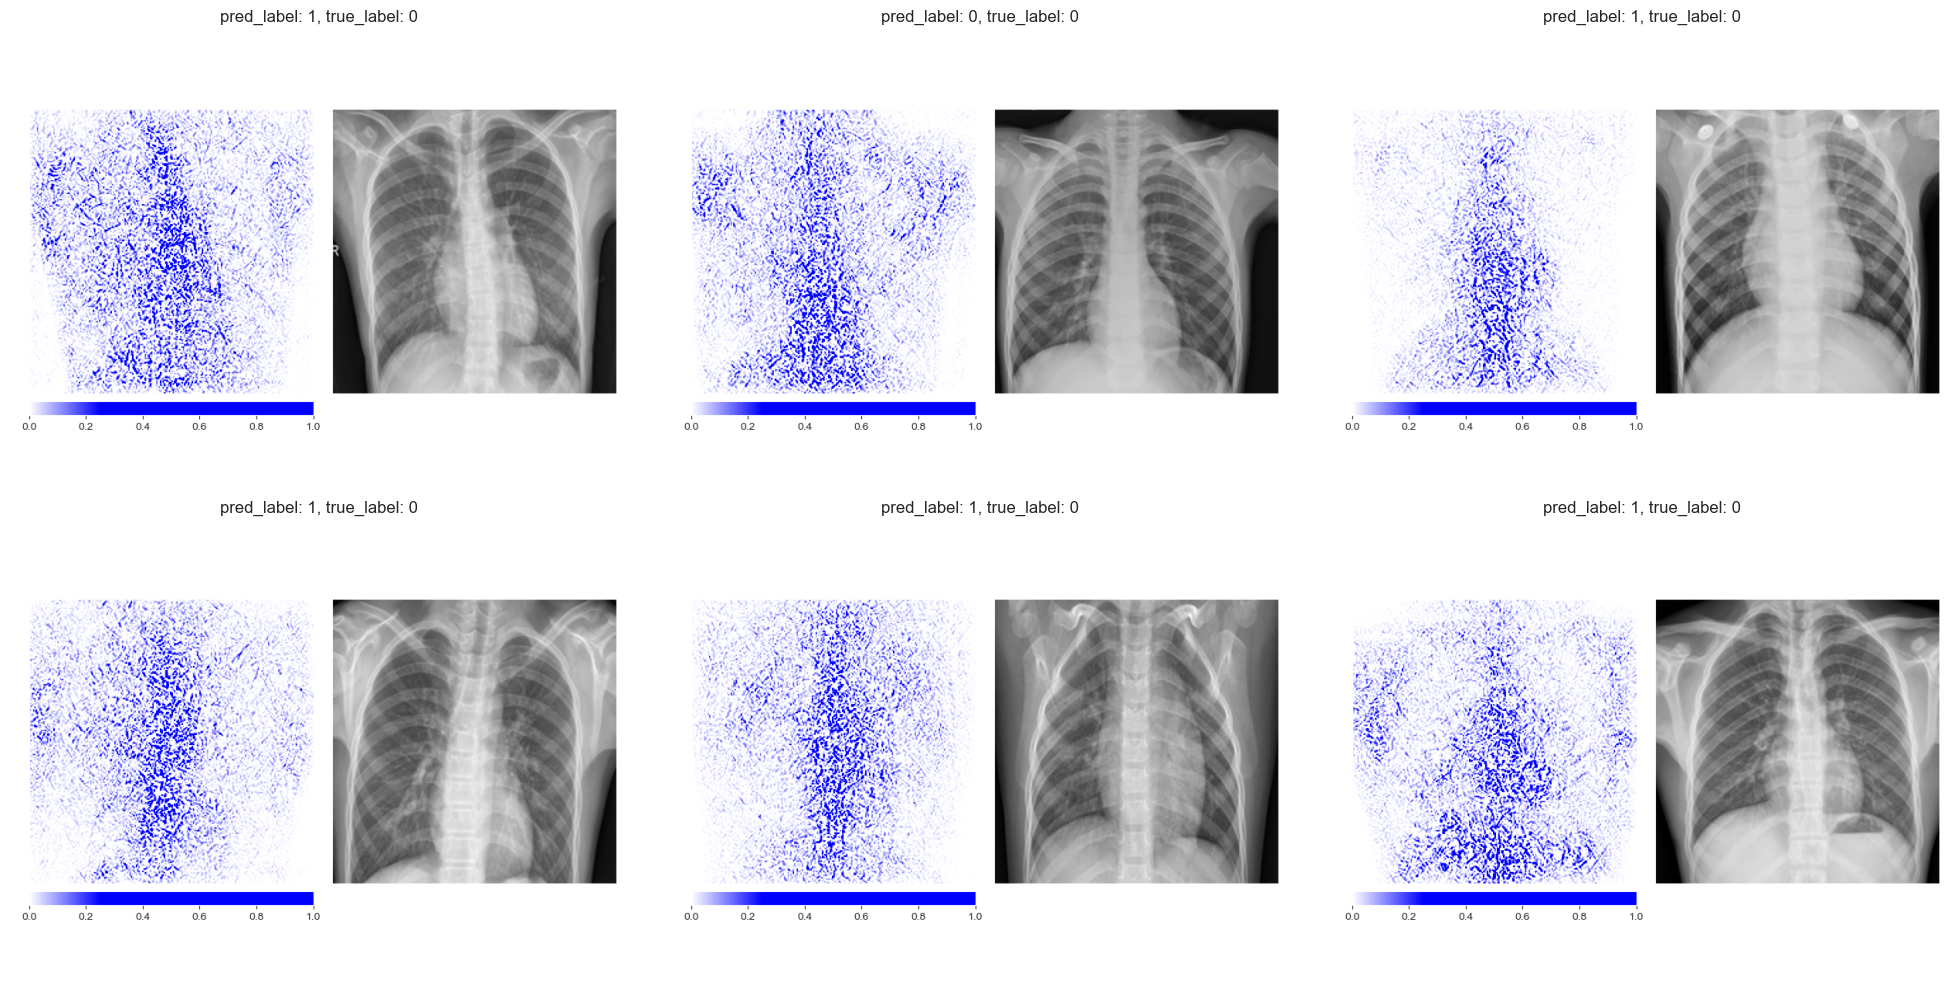

In [166]:
# Example usage:
plot_figures(attr_plot_0, pred_lab_0, true_lab_0,2,3)

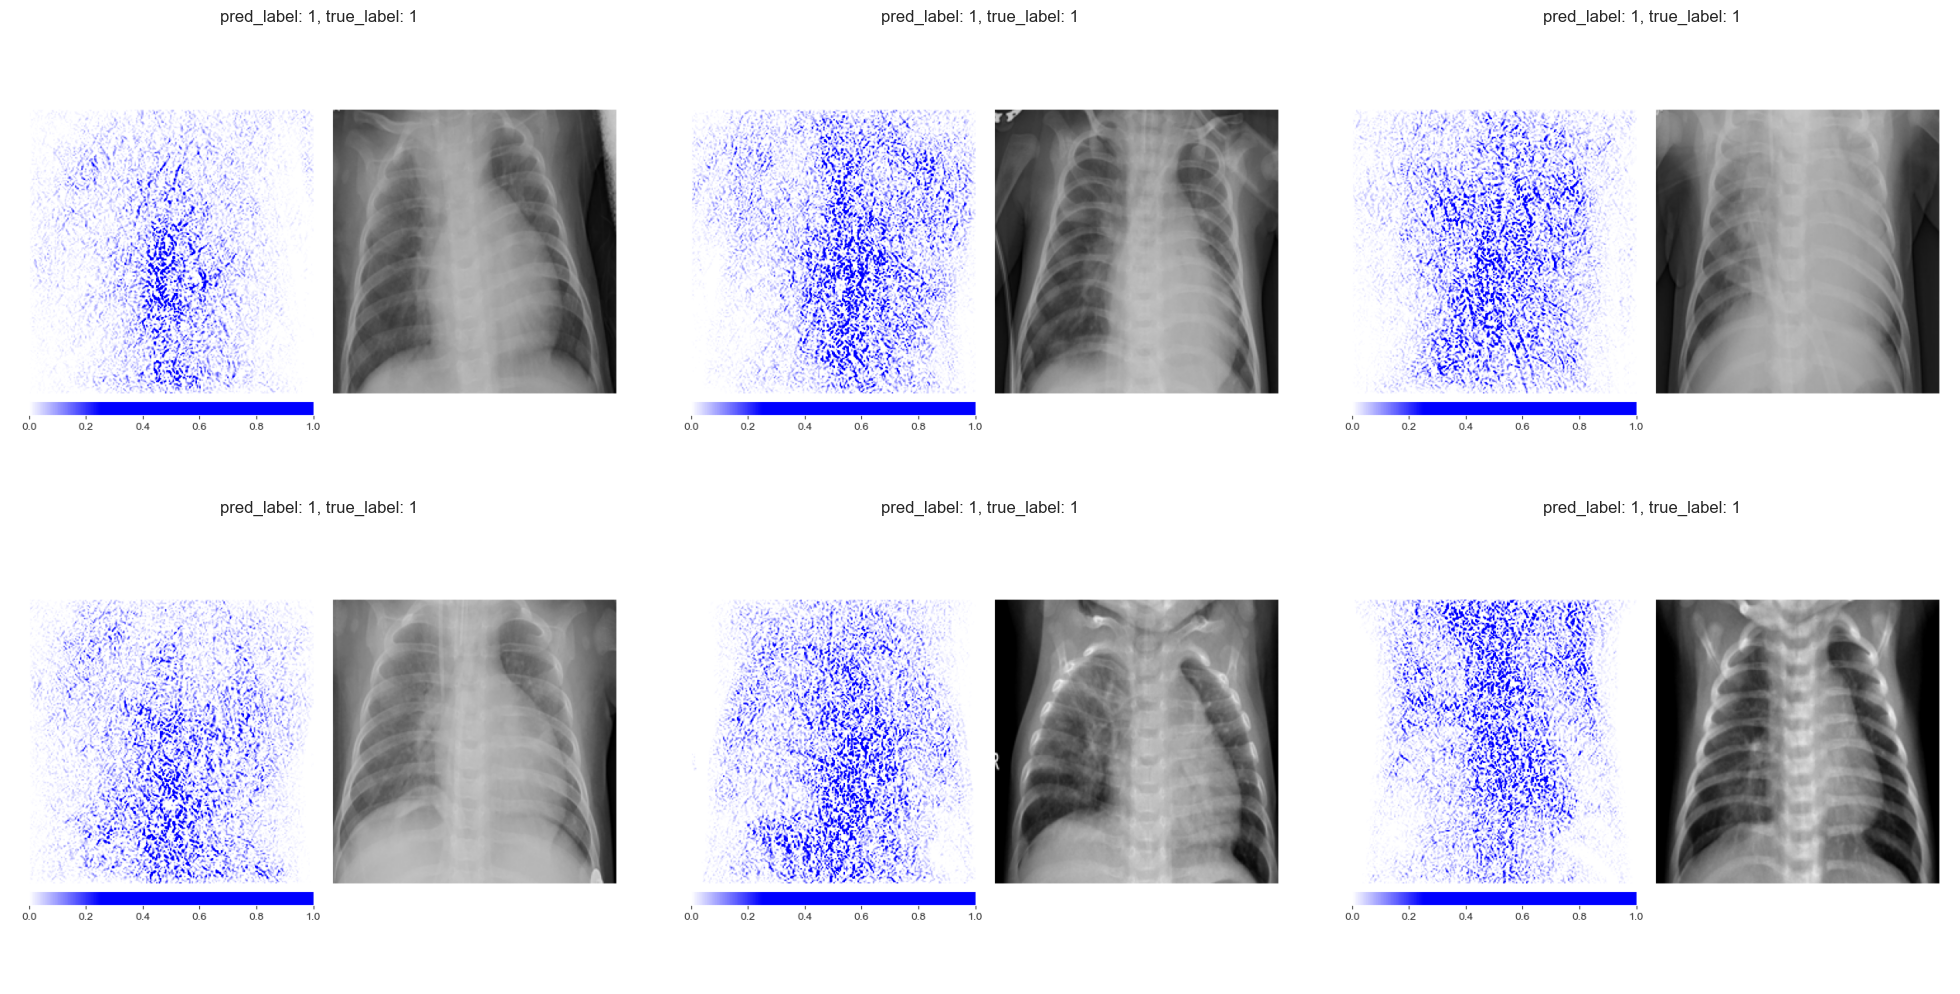

In [167]:
# Example usage:
plot_figures(attr_plot_1, pred_lab_1, true_lab_1, 2, 3)